In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

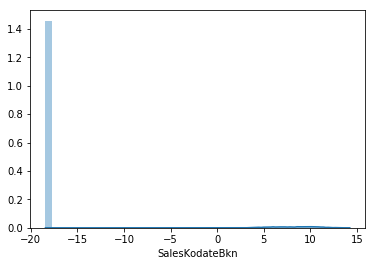

In [3]:
sns.distplot(np.log(df_train_Y['SalesKodateBkn'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['SalesKodateBkn']:
    df_train_Y['SalesKodateBkn_log'] = df_train_Y['SalesKodateBkn'].apply(log)
    df_val_Y['SalesKodateBkn_log'] = df_val_Y['SalesKodateBkn'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['SalesKodateBkn_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['SalesKodateBkn_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### xgboost モデルの作成

In [6]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=100, 
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:16.7935	eval-rmse:16.876
[1]	train-rmse:15.2251	eval-rmse:15.3599
[2]	train-rmse:13.8227	eval-rmse:14.0052
[3]	train-rmse:12.5659	eval-rmse:12.8069
[4]	train-rmse:11.4441	eval-rmse:11.7443
[5]	train-rmse:10.4431	eval-rmse:10.8001
[6]	train-rmse:9.55434	eval-rmse:9.9627
[7]	train-rmse:8.75872	eval-rmse:9.23527
[8]	train-rmse:8.0538	eval-rmse:8.60596
[9]	train-rmse:7.43094	eval-rmse:8.05003
[10]	train-rmse:6.87941	eval-rmse:7.56951
[11]	train-rmse:6.39446	eval-rmse:7.15373
[12]	train-rmse:5.96446	eval-rmse:6.80024
[13]	train-rmse:5.58832	eval-rmse:6.50176
[14]	train-rmse:5.25861	eval-rmse:6.24991
[15]	train-rmse:4.97548	eval-rmse:6.03446
[16]	train-rmse:4.72835	eval-rmse:5.85533
[17]	train-rmse:4.51072	eval-rmse:5.69874
[18]	train-rmse:4.3216	eval-rmse:5.56926
[19]	train-rmse:4.15757	eval-rmse:5.45403
[20]	train-rmse:4.01738	eval-rmse:5.36623
[21]	train-rmse:3.88803	eval-rmse:5.29142
[22]	train-rmse:3.7829	eval-rmse:5.22954
[23]	train-rmse:3.69434	eval-rmse:5.17656
[24]	tr

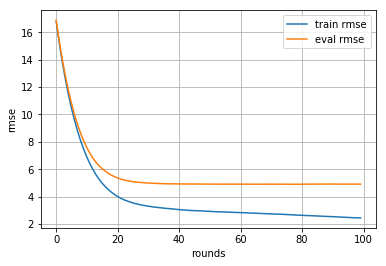

In [7]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

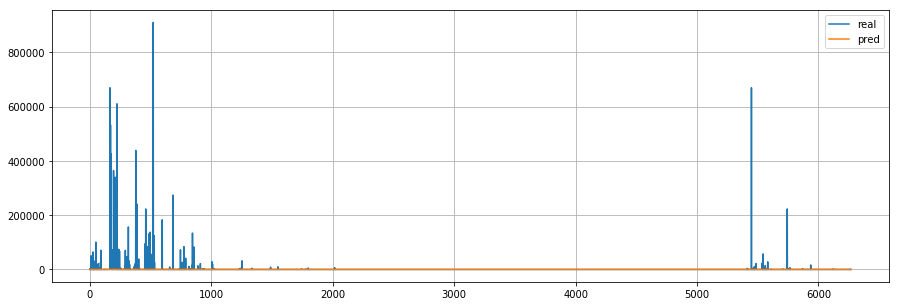

In [8]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['SalesKodateBkn'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

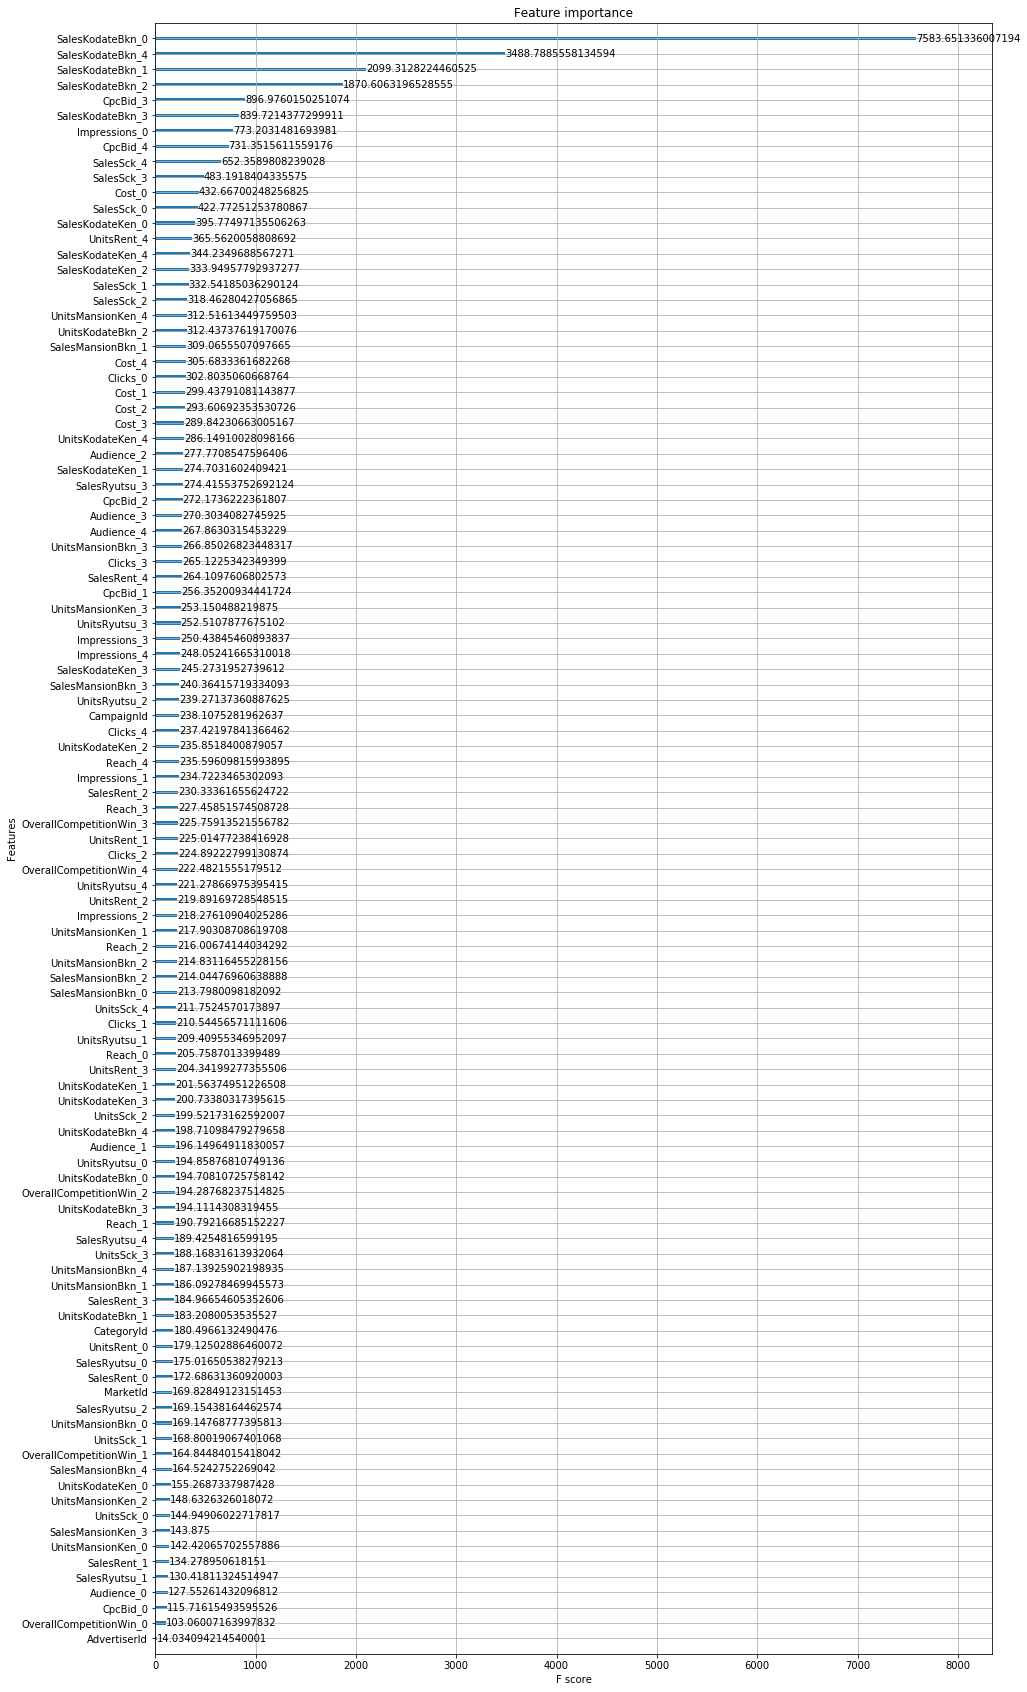

In [9]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [10]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['SalesKodateBkn_0',
 'SalesKodateBkn_4',
 'SalesKodateBkn_1',
 'SalesKodateBkn_2',
 'CpcBid_3',
 'SalesKodateBkn_3',
 'Impressions_0',
 'CpcBid_4',
 'SalesSck_4',
 'SalesSck_3',
 'Cost_0',
 'SalesSck_0',
 'SalesKodateKen_0',
 'UnitsRent_4',
 'SalesKodateKen_4',
 'SalesKodateKen_2',
 'SalesSck_1',
 'SalesSck_2',
 'UnitsMansionKen_4',
 'UnitsKodateBkn_2',
 'SalesMansionBkn_1',
 'Cost_4',
 'Clicks_0',
 'Cost_1',
 'Cost_2',
 'Cost_3',
 'UnitsKodateKen_4',
 'Audience_2',
 'SalesKodateKen_1',
 'SalesRyutsu_3',
 'CpcBid_2',
 'Audience_3',
 'Audience_4',
 'UnitsMansionBkn_3',
 'Clicks_3',
 'SalesRent_4',
 'CpcBid_1',
 'UnitsMansionKen_3',
 'UnitsRyutsu_3',
 'Impressions_3',
 'Impressions_4',
 'SalesKodateKen_3',
 'SalesMansionBkn_3',
 'UnitsRyutsu_2',
 'CampaignId',
 'Clicks_4',
 'UnitsKodateKen_2',
 'Reach_4',
 'Impressions_1',
 'SalesRent_2',
 'Reach_3',
 'OverallCompetitionWin_3',
 'UnitsRent_1',
 'Clicks_2',
 'OverallCompetitionWin_4',
 'UnitsRyutsu_4',
 'UnitsRent_2',
 'Impressions_2',
 